### Was machen Sachen?
- eigenes Modell auf allen Bildern aus meinem Ordner trainieren
- gucken was passiert, lol :)
- wir orientieren uns daran: https://huggingface.co/learn/diffusion-course/unit1/2

In [46]:
import torchvision
from datasets import load_dataset
from torchvision import transforms
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime

In [44]:
def save_img(img, path="results"):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    img.save(f"{path}/{timestamp}.png")

In [2]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


# Mac users may need device = 'mps' (untested)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
dataset = load_dataset("imagefolder", data_dir="training",split="train")


Resolving data files:   0%|          | 0/261 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [24]:
image_size = 32
# You can lower your batch size if you're running out of GPU memory
batch_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)

In [25]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}
dataset.set_transform(transform)

In [26]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [27]:
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)

X shape: torch.Size([8, 3, 32, 32])


C:\Users\marvi\AppData\Local\Temp\ipykernel_9552\387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


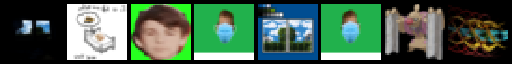

In [29]:
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [30]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Noisy X shape torch.Size([8, 3, 32, 32])


C:\Users\marvi\AppData\Local\Temp\ipykernel_9552\387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


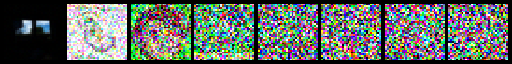

In [32]:
timesteps = torch.linspace(0, 999, 8).long().to(device)

noise = torch.randn_like(xb)

noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)

print("Noisy X shape", noisy_xb.shape)

show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

In [31]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [33]:
with torch.no_grad():
    model_prediction = model(noisy_xb, timesteps).sample
model_prediction.shape

torch.Size([8, 3, 32, 32])

In [34]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

c:\Users\marvi\Documents\Image_gen\.venv\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
c:\Users\marvi\Documents\Image_gen\.venv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch:5, loss: 0.21224684417247772
Epoch:10, loss: 0.18099741637706757
Epoch:15, loss: 0.1443275511264801
Epoch:20, loss: 0.14726060330867768
Epoch:25, loss: 0.12119075059890747
Epoch:30, loss: 0.14691196084022523


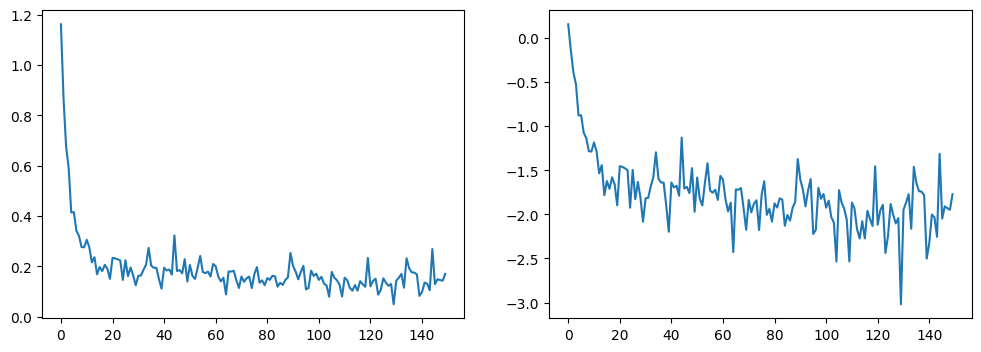

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [36]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
image_pipe.time

In [39]:
pipeline_output = image_pipe()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
save_img(pipeline_output.images[0])

In [48]:
image_pipe.save_pretrained("my_pipeline")

C:\Users\marvi\AppData\Local\Temp\ipykernel_9552\387830730.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


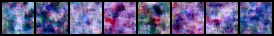

In [49]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)